# Training Pretrained 3D UNet with Dice Loss and Ranger - Model 1

This notebook contains the code that I used to train the pretrained 3D U-Net model using the Dice Loss function and the Ranger optimizer.

## Installing and Importing Libraries

In [ ]:
!pip install segmentation_models==1.0.1 # I deleted the output of this cell since it is irrelevant.
!pip install nilearn
!pip install tensorflow-addons

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f1fa9b00-a998-64df-a927-44f378359088)


In [ ]:
# utils
import h5py
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import json
from util import load_case
from dataprocessing import get_sub_volume, standardize, CreateSubVolumes, get_config
from losses import soft_dice_loss, dice_coefficient
import segmentation_models as sm
import util

# neural imaging
import nilearn as nl
import nibabel as nib
import numpy as np

# ml libs
import keras
import keras.backend as K
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from keras.callbacks import Callback, ModelCheckpoint

#Plots
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading and Pre-processing the Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xvf "/content/drive/MyDrive/Task01_BrainTumour.tar" -C "/content/" 

The `CreateSubVolumes()` function creates a new folder named **subvolumes** and adds subvolumes to it.

In [4]:
jsonfile_path="/content/Task01_BrainTumour/dataset.json"
outputpath="/content/subvolumes/"

In [5]:
CreateSubVolumes(jsonfile_path,outputpath)

Creating the training list...


100%|██████████| 484/484 [00:00<00:00, 1023723.22it/s]




Creating the sub-volumes... 


100%|██████████| 484/484 [16:54<00:00,  2.10s/it]



For 84 files, could not find a sub-volume after trying 1000 times.


In the following code, I create a config file and split the data into train and validation sets.

In [6]:
h5_path="/content/subvolumes"
get_config(h5_path,0.20) # %20 of the data is used for validation.
with open("/content/config.json") as json_file:
    config = json.load(json_file)

In [7]:
# Get generators for training and validation sets
train_generator = util.VolumeDataGenerator(config["train"], "/content/subvolumes/", batch_size=6, dim=(160, 160, 16), verbose=0)
valid_generator = util.VolumeDataGenerator(config["valid"], "/content/subvolumes/", batch_size=6, dim=(160, 160, 16), verbose=0)
train_generator

Let's check the shapes.

In [8]:
data = next(iter(train_generator))
data[0].shape, data[1].shape

((6, 4, 160, 160, 16), (6, 3, 160, 160, 16))

## Training the Models

Now, I can finally start training the model. I will train three models using the Soft Dice Loss with 0.00001 - 0.00000001, 0.000001 - 0.000000001, and 0.0000001 - 0.0000000001 learning rate ranges.

### Model 1 : initial_lr = 0.00001 and final_lr = 0.00000001

In [9]:
tf.keras.backend.clear_session()
model_dice = util.unet_model_3d(loss_function=soft_dice_loss, initial_learning_rate=0.00001, final_learning_rate=0.00000001, deconvolution=False, ranger=True,
                               batch_normalization=False, metrics=['accuracy',dice_coefficient, sm.metrics.IOUScore(threshold=0.5)])

In [10]:
model_dice.load_weights("/content/drive/MyDrive/model_pretrained.hdf5")

In [ ]:
checkpoint = ModelCheckpoint(
    'model_dice_ranger1.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'

)

history=model_dice.fit_generator(generator=train_generator,
        epochs=25,
        validation_data=valid_generator,
        callbacks=[checkpoint])

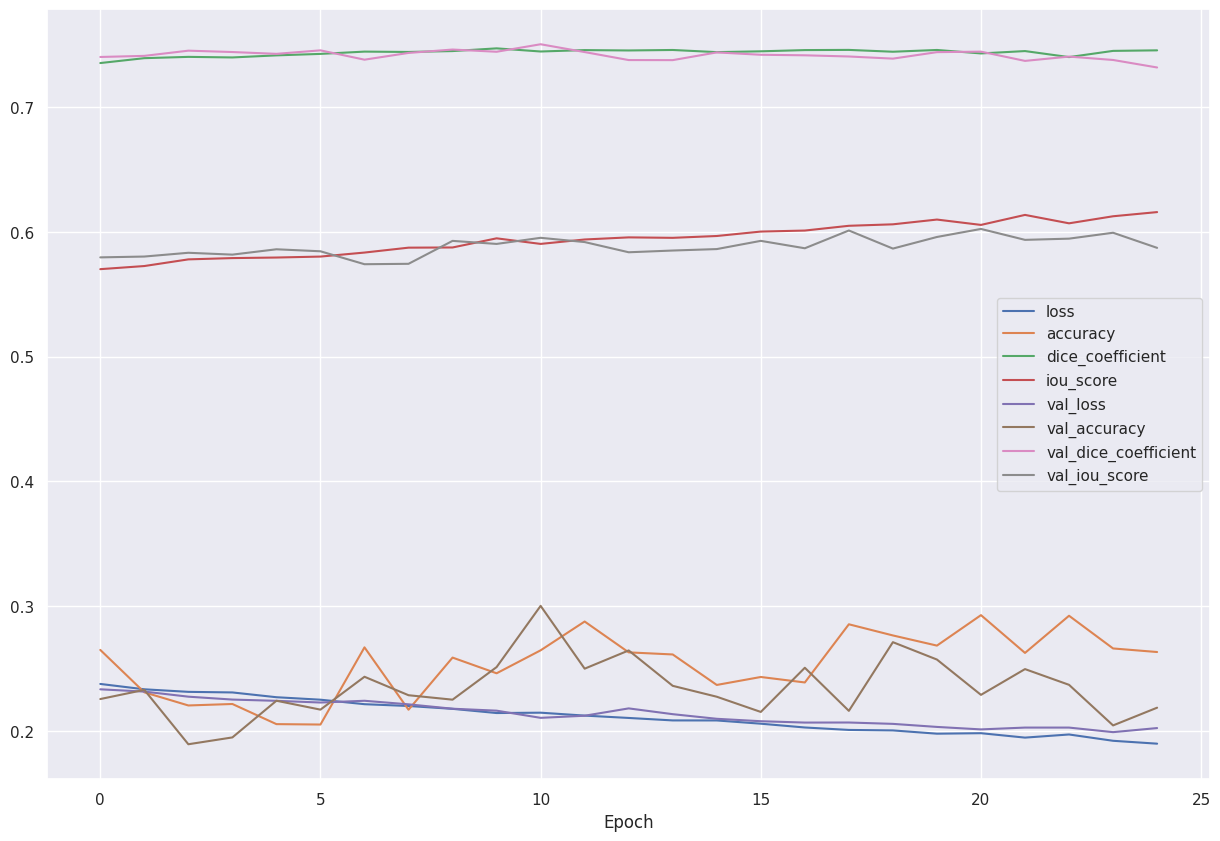

In [12]:
sns.set_theme()
pd.DataFrame(history.history).plot(figsize=(15, 10))
plt.xlabel("Epoch")
plt.legend(loc="best")
plt.show()

In [13]:
!cp -r '/content/model_dice_ranger1.h5' /content/drive/MyDrive/ # Saving the weights.

### Model 2 : initial_lr = 0.000001 and final_lr = 0.000000001

In [8]:
tf.keras.backend.clear_session()
model_dice2 = util.unet_model_3d(loss_function=soft_dice_loss, initial_learning_rate=0.000001, final_learning_rate=0.000000001, deconvolution=False, ranger=True,
                               batch_normalization=False, metrics=['accuracy',dice_coefficient, sm.metrics.IOUScore(threshold=0.5)])

In [9]:
model_dice2.load_weights("/content/drive/MyDrive/model_pretrained.hdf5")

In [ ]:
checkpoint2 = ModelCheckpoint(
    'model_dice_ranger2.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'

)

history2=model_dice2.fit_generator(generator=train_generator,
        epochs=25,
        validation_data=valid_generator,
        callbacks=[checkpoint2])

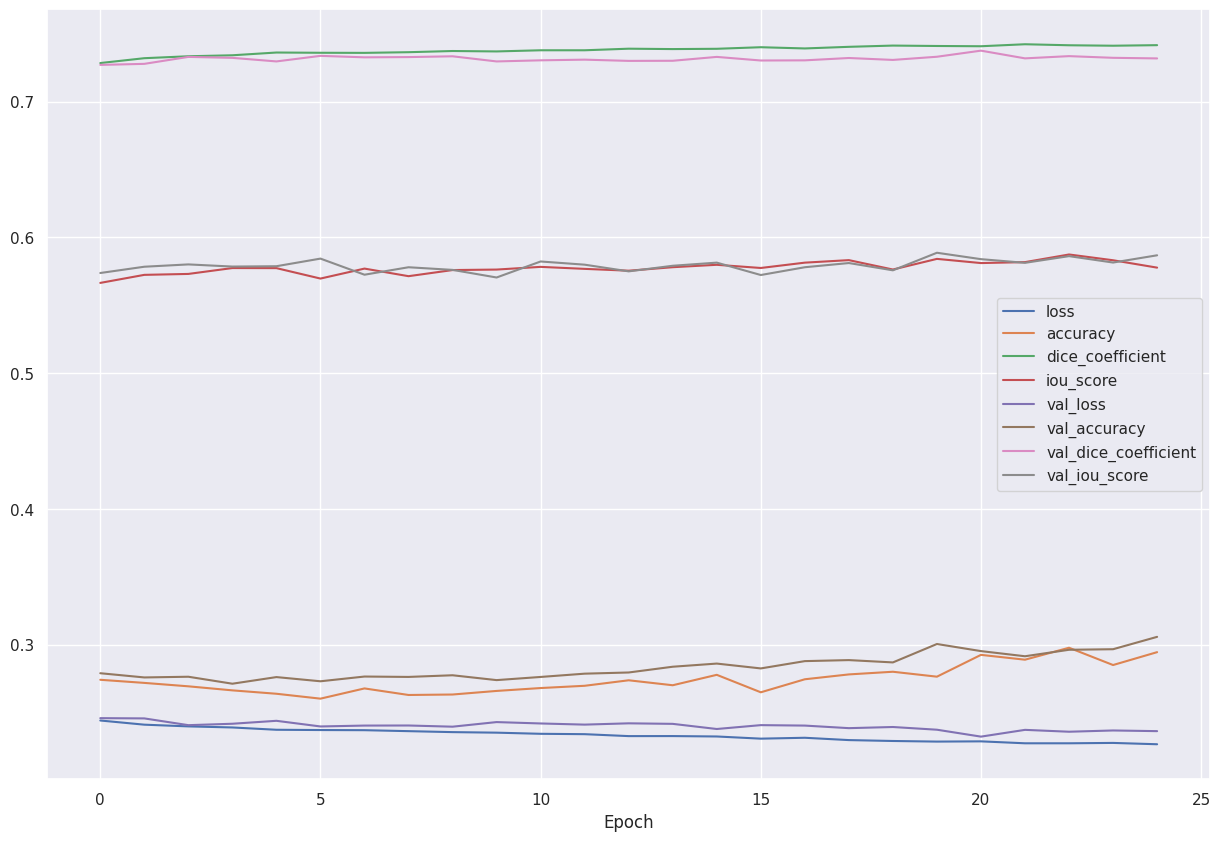

In [11]:
sns.set_theme()
pd.DataFrame(history2.history).plot(figsize=(15, 10))
plt.xlabel("Epoch")
plt.legend(loc="best")
plt.show()

In [12]:
!cp -r '/content/model_dice_ranger2.h5' /content/drive/MyDrive/ # Saving the weights.

### Model 3 : initial_lr = 0.0000001 and final_lr = 0.0000000001

In [9]:
tf.keras.backend.clear_session()
model_dice3 = util.unet_model_3d(loss_function=soft_dice_loss, initial_learning_rate=0.0000001, final_learning_rate=0.0000000001, deconvolution=False, ranger=True,
                               batch_normalization=False, metrics=['accuracy',dice_coefficient, sm.metrics.IOUScore(threshold=0.5)])

In [10]:
model_dice3.load_weights("/content/drive/MyDrive/model_pretrained.hdf5")

In [ ]:
checkpoint3 = ModelCheckpoint(
    'model_dice_ranger3.h5', 
    monitor='val_loss', 
    verbose=1,  save_weights_only=False,
    mode='auto'

)

history3=model_dice3.fit_generator(generator=train_generator,
        epochs=25,
        validation_data=valid_generator,
        callbacks=[checkpoint3])

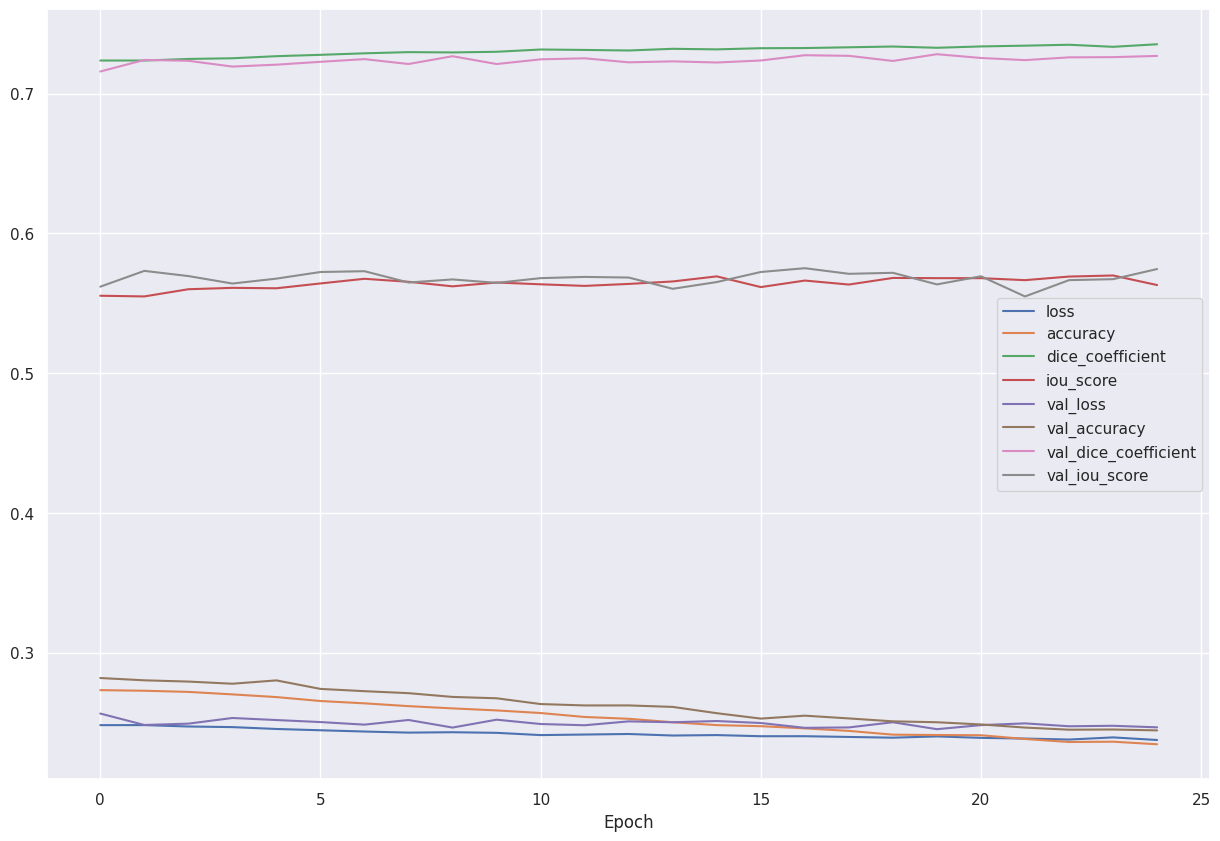

In [12]:
sns.set_theme()
pd.DataFrame(history3.history).plot(figsize=(15, 10))
plt.xlabel("Epoch")
plt.legend(loc="best")
plt.show()

In [13]:
!cp -r '/content/model_dice_ranger3.h5' /content/drive/MyDrive/ # Saving the weights.